## Imports

In [ ]:
#pip install tensorflow

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache
import cv2
import os

We need to import several things from Keras.

In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

This was developed using Python 3.6 (Anaconda) and package versions:

In [6]:
tf.__version__

'2.4.1'

In [7]:
tf.keras.__version__

'2.4.0'

## Load Data

We will use the COCO data-set which contains many images with text-captions.

http://cocodataset.org

In [8]:
import coco

You can change the data-directory if you want to save the data-files somewhere else.

In [9]:
# coco.set_data_dir("data/coco/")

In [10]:
coco.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


Get the filenames and captions for the images in the training-set.

In [11]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: data/coco/records_train.pkl


Number of images in the training-set.

In [12]:
num_images_train = len(filenames_train)
num_images_train

118287

Get the filenames and captions for the images in the validation-set.

In [13]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: data/coco/records_val.pkl


### Helper-Functions for Loading and Showing Images

This is a helper-function for loading and resizing an image.

In [14]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

This is a helper-function for showing an image from the data-set along with its captions.

In [15]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Example Image

Show an example image and captions from the training-set.

A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


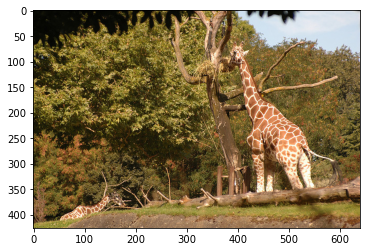

In [16]:
show_image(idx=1, train=True)

## Pre-Trained Image Model (VGG16)

The following creates an instance of the VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model was pre-trained on the ImageNet data-set for classifying images. The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for the image classification.



In [17]:
image_model = VGG16(include_top=True, weights='imagenet')

Print a list of all the layers in the VGG16 model.

In [18]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We will use the output of the layer prior to the final classification-layer which is named `fc2`. This is a fully-connected (or dense) layer.

In [19]:
transfer_layer = image_model.get_layer('fc2')

We call it the "transfer-layer" because we will transfer its output to another model that creates the image captions.

To do this, first we need to create a new model which has the same input as the original VGG16 model but outputs the transfer-values from the `fc2` layer.

In [20]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

The model expects input images to be of this size:

In [21]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

For each input image, the new model will output a vector of transfer-values with this length:

In [22]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### Process All Images

We now make functions for processing all images in the data-set using the pre-trained image-model and saving the transfer-values in a cache-file so they can be reloaded quickly.

We effectively create a new data-set of the transfer-values. This is because it takes a long time to process an image in the VGG16 model. We will not be changing all the parameters of the VGG16 model, so every time it processes an image, it gives the exact same result. We need the transfer-values to train the image-captioning model for many epochs, so we save a lot of time by calculating the transfer-values once and saving them in a cache-file.

This is a helper-function for printing the progress.

In [23]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

This is the function for processing the given files using the VGG16-model and returning their transfer-values.

In [24]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Helper-function for processing all images in the training-set. This saves the transfer-values in a cache-file for fast reloading.

In [25]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

Helper-function for processing all images in the validation-set.

In [26]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

Process all images in the training-set and save the transfer-values to a cache-file. This took about 30 minutes to process on a GTX 1070 GPU.

In [27]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Progress: 100.0%
- Data saved to cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
Wall time: 9h 58min 44s


Process all images in the validation-set and save the transfer-values to a cache-file. This took about 90 seconds to process on a GTX 1070 GPU.

In [28]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Progress: 99.8%
- Data saved to cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
Wall time: 24min 44s


## Tokenizer

Neural Networks cannot work directly on text-data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into so-called integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer. See Tutorial #20 for a more detailed explanation.

Before we can start processing the text, we first need to mark the beginning and end of each text-sequence with unique words that most likely aren't present in the data.

In [29]:
mark_start = 'ssss '
mark_end = ' eeee'

This helper-function wraps all text-strings in the above markers. Note that the captions are a list of list, so we need a nested for-loop to process it. This can be done using so-called list-comprehension in Python.

In [30]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

Now process all the captions in the training-set and show an example.

In [31]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

This is how the captions look without the start- and end-markers.

In [32]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

This helper-function converts a list-of-list to a flattened list of captions.

In [33]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

Now use the function to convert all the marked captions from the training set.

In [34]:
captions_train_flat = flatten(captions_train_marked)

Set the maximum number of words in our vocabulary. This means that we will only use e.g. the 10000 most frequent words in the captions from the training-data.

In [35]:
num_words = 10000

We need a few more functions than provided by Keras' Tokenizer-class so we wrap it.

In [36]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

Now create a tokenizer using all the captions in the training-data. Note that we use the flattened list of captions to create the tokenizer because it cannot take a list-of-lists.

In [37]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

Wall time: 11.2 s


Get the integer-token for the start-marker (the word "ssss"). We will need this further below.

In [38]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

Get the integer-token for the end-marker (the word "eeee").

In [39]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

Convert all the captions from the training-set to sequences of integer-tokens. We get a list-of-list as a result.

In [40]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

Wall time: 10.3 s


Example of the integer-tokens for the captions of the first image in the training-set:

In [41]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

These are the corresponding text-captions:

In [42]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

## Data Generator

Each image in the training-set has at least 5 captions describing the contents of the image. The neural network will be trained with batches of transfer-values for the images and sequences of integer-tokens for the captions. If we were to have matching numpy arrays for the training-set, we would either have to only use a single caption for each image and ignore the rest of this valuable data, or we would have to repeat the image transfer-values for each of the captions, which would waste a lot of memory.

A better solution is to create a custom data-generator for Keras that will create a batch of data with randomly selected transfer-values and token-sequences.

This helper-function returns a list of random token-sequences for the images with the given indices in the training-set.

In [43]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

This generator function creates random batches of training-data for use in training the neural network.

In [44]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [45]:
batch_size = 384

Create an instance of the data-generator.

In [46]:
generator = batch_generator(batch_size=batch_size)

Test the data-generator by creating a batch of data.

In [47]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

Example of the transfer-values for the first image in the batch.

In [48]:
batch_x['transfer_values_input'][0]

array([0.     , 0.12427, 1.405  , ..., 0.     , 0.     , 0.5    ],
      dtype=float16)

Example of the token-sequence for the first image in the batch. This is the input to the decoder-part of the neural network.

In [49]:
batch_x['decoder_input'][0]

array([   2, 1215,  733,  667,    7, 6101, 1536,  142,    1, 2058,    5,
        957,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0])

This is the token-sequence for the output of the decoder. Note how it is the same as the sequence above, except it is shifted one time-step.

In [50]:
batch_y['decoder_output'][0]

array([1215,  733,  667,    7, 6101, 1536,  142,    1, 2058,    5,  957,
          3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

### Steps Per Epoch

One epoch is a complete processing of the training-set. We would like to process each image and caption pair only once per epoch.

In [51]:
num_captions_train = [len(captions) for captions in captions_train]

This is the total number of captions in the training-set.

In [52]:
total_num_captions_train = np.sum(num_captions_train)

This is the approximate number of batches required per epoch, if we want to process each caption and image pair once per epoch.

In [53]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

1541

## Create the Recurrent Neural Network

We will now create the Recurrent Neural Network (RNN) that will be trained to map the vectors with transfer-values from the image-recognition model into sequences of integer-tokens that can be converted into text. We call this neural network for the 'decoder'.


In [54]:
state_size = 512

The embedding-layer converts integer-tokens into vectors of this length:

In [55]:
embedding_size = 128

This inputs transfer-values to the decoder:

In [56]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')



### We use a `tanh` activation function to limit the output of the mapping between -1 and 1, otherwise this does not seem to work.

In [57]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

This is the input for token-sequences to the decoder. Using `None` in the shape means that the token-sequences can have arbitrary lengths.

In [58]:
decoder_input = Input(shape=(None, ), name='decoder_input')

This is the embedding-layer which converts sequences of integer-tokens to sequences of vectors.

In [59]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

This creates the 3 GRU layers of the decoder. Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [60]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

The GRU layers output a tensor with shape `[batch_size, sequence_length, state_size]`, where each "word" is encoded as a vector of length `state_size`. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

One way of doing this is to convert the GRU output to a one-hot encoded array. It works but it is extremely wasteful, because for a vocabulary of e.g. 10000 words we need a vector with 10000 elements, so we can select the index of the highest element to be the integer-token.

In [61]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

### Connect and Create the Training Model

The decoder is built using the functional API of Keras, which allows more flexibility in connecting the layers e.g. to have multiple inputs. This is useful e.g. if you want to connect the image-model directly with the decoder instead of using pre-calculated transfer-values.

This function connects all the layers of the decoder to some input of transfer-values.

In [62]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

Connect and create the model used for training. This takes as input transfer-values and sequences of integer-tokens and outputs sequences of one-hot encoded arrays that can be converted into integer-tokens.

In [63]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### Compile the Model

The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 10000 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays. We could do this conversion from integers to one-hot arrays in the `batch_generator()` above.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays.

Optimizer used:  RMSprop 

In [64]:
decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss='sparse_categorical_crossentropy')

### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [65]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

This is the callback for writing the TensorBoard log during training.

In [66]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [67]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

You can reload the last saved checkpoint so you don't have to train the model every time you want to use it.

In [68]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = '22_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Train the Model

Now we will train the decoder so it can map transfer-values from the image-model to sequences of integer-tokens for the captions of the images.

One epoch of training took about 7 minutes on a GTX 1070 GPU. You probably need to run 20 epochs or more during training.

Note that if we didn't use pre-computed transfer-values then each epoch would take maybe 40 minutes to run, because all the images would have to be processed by the VGG16 model as well.

In [69]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=20,
                  callbacks=callbacks)

Epoch 1/20
1541/1541 [==============================] - 12074s 8s/step - loss: 1.8949

Epoch 00001: saving model to 22_checkpoint.keras
Epoch 2/20
1541/1541 [==============================] - 12521s 8s/step - loss: 1.2338

Epoch 00002: saving model to 22_checkpoint.keras
Epoch 3/20
1541/1541 [==============================] - 12155s 8s/step - loss: 1.1541

Epoch 00003: saving model to 22_checkpoint.keras
Epoch 4/20
1541/1541 [==============================] - 12066s 8s/step - loss: 1.1372

Epoch 00004: saving model to 22_checkpoint.keras
Epoch 5/20
1541/1541 [==============================] - 12038s 8s/step - loss: 1.1174

Epoch 00005: saving model to 22_checkpoint.keras
Epoch 6/20
1541/1541 [==============================] - 12720s 8s/step - loss: 1.0938

Epoch 00006: saving model to 22_checkpoint.keras
Epoch 7/20
1541/1541 [==============================] - 13257s 9s/step - loss: 1.0793

Epoch 00007: saving model to 22_checkpoint.keras
Epoch 8/20
1541/1541 [==========================

## Generate Captions

This function loads an image and generates a caption using the model we have trained.

In [230]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

   

    #img = cv2.imread(image, 1)
    #path = 'C:/Users/Admin/Desktop/Analyttica certifications/MKR/task5/caption_gen/output'
    #cv2.imwrite(os.path.join(path , 'display.jpg'), img)
    #cv2.waitKey(0)
                     
     # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text[:-4])
    return image,output_text[:-4]
    
    print()

In [204]:

pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


### Examples

Try this with a picture of a parrot.

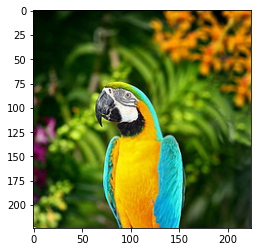

Predicted caption:
 a bird is sitting on a branch with leaves 



In [115]:
generate_caption("images/parrot_cropped1.jpg")

Try it with a picture of a person (Elon Musk). In Tutorial #07 the Inception model mis-classified this picture as being either a sweatshirt or a cowboy boot.

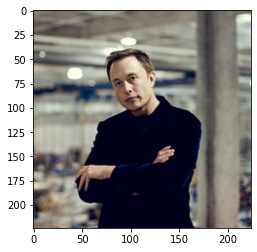

Predicted caption:
 a man in a suit and tie is smiling 



In [116]:
generate_caption("images/elon_musk.jpg")

Helper-function for loading an image from the COCO data-set and printing the true captions as well as the predicted caption.

In [231]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)
    #print(path)

    # Use the model to generate a caption of the image.
    image_disp, predicted_text = generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    fill_caption =[]
    for caption in captions:
        fill_caption.append(caption)
    #print(path, fill_caption)
    return image_disp ,fill_caption, predicted_text

Try this on a picture from the training-set that the model has been trained on. In some cases the generated caption is actually better than the human-generated captions.

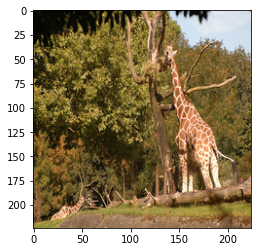

Predicted caption:
 a giraffe standing in a field with trees in the background 
True captions:


' a giraffe standing in a field with trees in the background '

In [233]:
a,b,c = generate_caption_coco(idx=1, train=True)
c
            

Here is another picture of giraffes from the training-set, so this image was also used during training of the model. But the model can't produce an accurate caption. Perhaps it needs more training, or perhaps another architecture for the Recurrent Neural Network?

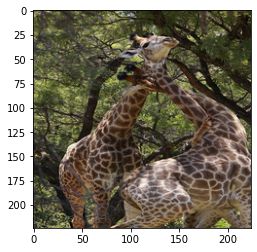

Predicted caption:
 a large brown bear walking through a forest 

True captions:
A couple of giraffe snuggling each other in a forest.


'data/coco/train2017\\000000000072.jpgA couple of giraffe snuggling each other in a forest.'

In [167]:
generate_caption_coco(idx=10, train=True)

Here is a picture from the validation-set which was not used during training of the model. Sometimes the model can produce good captions for images it hasn't seen during training and sometimes it can't. Can you make a better model?

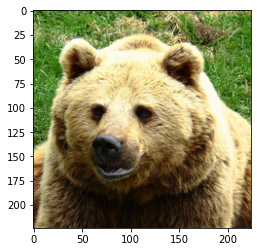

Predicted caption:
 a dog is walking in the grass with a frisbee 

True captions:
A big burly grizzly bear is show with grass in the background.


'data/coco/val2017\\000000000285.jpgA big burly grizzly bear is show with grass in the background.'

In [168]:
generate_caption_coco(idx=1, train=False)

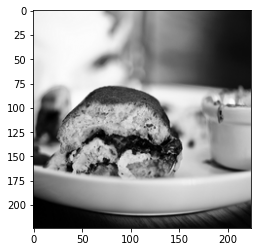

Predicted caption:
 a white plate topped with a sandwich and a salad 

True captions:


'data/coco/val2017\\000000001425.jpgA meal is lying on a plate on a table.'

In [174]:
generate_caption_coco(idx=13, train=False)

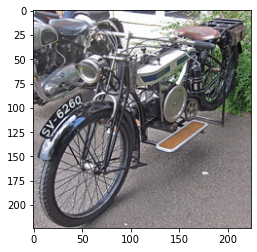

Predicted caption:
 a row of motorcycles parked next to each other 

True captions:
A motorcycle parked in a parking space next to another motorcycle.
An old motorcycle parked beside other motorcycles with a brown leather seat.
Motorcycle parked in the parking lot of asphalt.
A close up view of a motorized bicycle, sitting in a rack. 
The back tire of an old style motorcycle is resting in a metal stand. 


In [153]:
generate_caption_coco(idx=11, train=True)

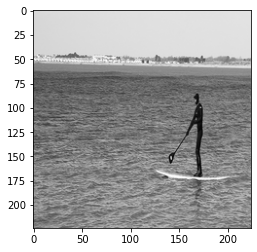

Predicted caption:
 a large body of water with a boat floating on it 

True captions:
A man in a wet suit stands on a surfboard and rows with a paddle.
A paddle boarder on a large, still body of water.
A man is holding a long racquet on a surfboard in the middle of the sea.
Black and white of a person wearing a wetsuit standing on a surfboard and holding out a paddle, in a large body of water outside.
A man with a wet suit on standing on a surfboard in the water.


In [155]:
generate_caption_coco(idx=14, train=False)

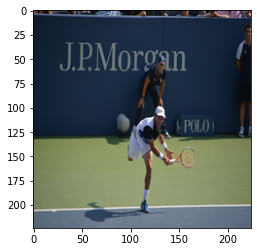

Predicted caption:
 a woman is playing tennis on a tennis court 

True captions:
a male tennis player in white shorts is playing tennis
This woman has just returned a volley in tennis
A man holding a tennis racket playing tennis.
The man balances on one leg after serving a tennis ball.
Someone playing in a tennis tournament with a crowd looking on.


In [123]:
generate_caption_coco(idx=8, train=False)

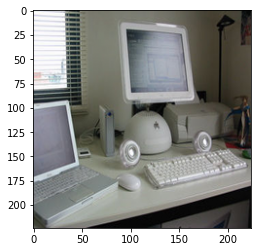

Predicted caption:
 a bathroom with a sink toilet and shower 

True captions:
A computer on a desk next to a laptop.
A picture of an iMac desktop next to a Mac laptop on a desk. 
Two apple computers are on a white desk
A laptop and desktop computer on a white desk
A computer desk with several pieces of computer equipment.


In [124]:
generate_caption_coco(idx=15, train=False)

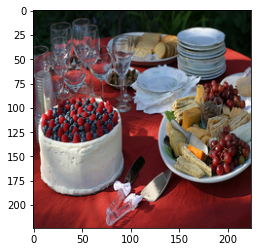

Predicted caption:
 a table with a plate of food and a glass of water 

True captions:
A plate of finger foods next to a blue and raspberry topped cake.
A nicely set dining table filled with food and a cake topped with berries.
a close up of a table with many plates of food
A table topped with a cake covered in berries next to a plate of sandwiches.
A white cake topped with berries and a plate of fruit and cheeses.


In [125]:
generate_caption_coco(idx=25, train=False)

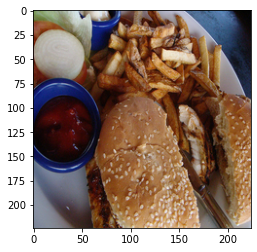

Predicted caption:
 a plate of food with a sandwich and a cup of soup 

True captions:
A plate of food which includes onions, tomato, lettuce, sauce, fries, and a sandwich.
A sandwich, french fries, bowl of ketchup, onion slice, lettuce slice, tomato slice, and knife sit on the white plate.
Partially eaten hamburger on a plate with fries and condiments. 
A grilled chicken sandwich sits beside french fries made with real potatoes. 
A sandwich on a sesame seed bun next to a pile of french fries and a cup of ketchup.


In [126]:
generate_caption_coco(idx=100, train=False)

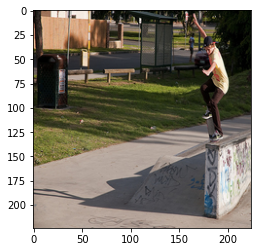

Predicted caption:
 a person riding a bike down a street with a umbrella 

True captions:
A young man riding a skateboard on a stone wall.
A boy riding his skateboard on a ledge in a park.
Young man on skate board balancing on concrete barrier near sidewalk with small park area near by.
A man on a skateboard doing tricks at the park
A skateboarder is doing a trick on the edge of a ledge.


In [127]:
 generate_caption_coco(idx=130, train=False)


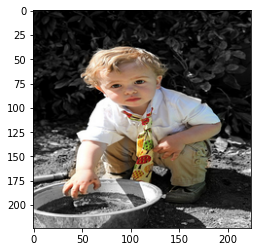

Predicted caption:
 a man is holding a sandwich in his hands 

True captions:
A young child squats down in front of a bowl.
a little boy kneeling down while attempting to stick his hand in a bowl of water
A young boy dressed in a tie plays outside by a water bowl.
Nicely dressed little boy gets ready to play in the dirt.
A little boy dipping his hand into water.


In [128]:
generate_caption_coco(idx=200, train=False)

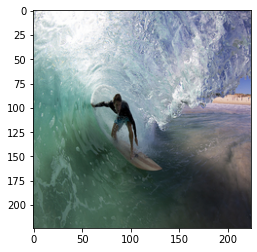

Predicted caption:
 a person on a surfboard in the water 

True captions:
A man riding a wave on top of a white surfboard.
A photo inside and ocean wave looking at a person on a surfboard.
A crashing wave is about to close in on a surfer.  
A man riding a wave on a surf board.
A man on a surfboard inside a large wave.


In [129]:
generate_caption_coco(idx=300, train=False)

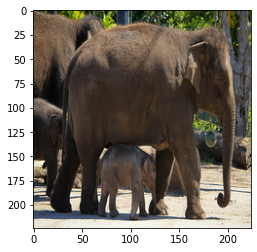

Predicted caption:
 a large elephant walking through a lush green field 

True captions:
An adult elephant is pictured walking with a baby elephant.
A baby elephant walks with an older elephant
A baby elephant walks between the legs of its mother.
A baby elephant walking along the same path as its mother. 
a bunch of elephants are standing together in a pin


In [130]:
generate_caption_coco(idx=500, train=False)

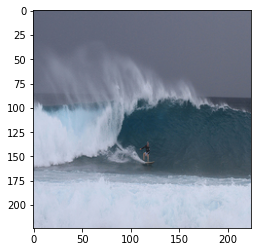

Predicted caption:
 a person on a surfboard in the water 

True captions:
A person riding a wave on top of a surfboard.
Man surfing a wave on a dull day.
a surfer riding in a stormy looking wave
This person is riding a big wave on the water.
A person on a surf board by a big wave.


In [137]:
generate_caption_coco(idx=450, train=False)

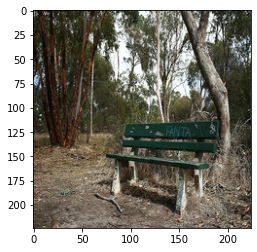

Predicted caption:
 a bench sitting in the middle of a forest 

True captions:
A green park bench underneath a tree in a park.
A green bench with graffiti in an area with trees.  
An empty green park bench sitting among overgrowth.
A park bench with graffiti sitting next to dead grass.
a green bench with graffiti on it near a wooded area


In [140]:
generate_caption_coco(idx=4550, train=False)

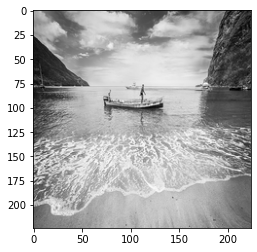

Predicted caption:
 a boat is sitting on the shore of a lake 

True captions:
A man sanding on a boat next to a beach.
A man stands on a fishing boat as the tide rolls in from the shore on a desolate beach.
A black and white image of two boats on the water in between two mountains.
A man standing in a boat near shore
Shot of a person in a wooden boat on the shore of a beach.


In [144]:
generate_caption_coco(idx=4900, train=False)

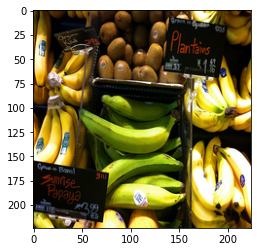

Predicted caption:
 a table topped with a plate of food and a cup of coffee 

True captions:
A store display filled with ripe, unripe bananas and other fruit.
A group of bananas surround a small display of kiwi.
A fruit stand with plantains, kiwis, and bananas. 
A fruit stand that has bananas, papaya, and plantains.  
A fruit stand display with bananas and kiwi


In [145]:
generate_caption_coco(idx=4999, train=False)

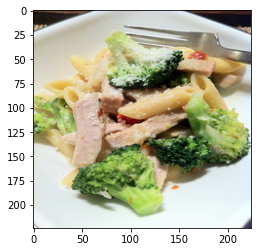

Predicted caption:
 a plate of food with broccoli and meat 

True captions:
A plate of broccoli, ham, pasta and parmesan.
A white plate with noodles, chicken and broccoli.
A small portion of broccoli, ham, and pasta salad
a close up of a plate of food with broccoli
A plate of prepared food has pasta, broccoli, and meat.


In [148]:
generate_caption_coco(idx = 4800, train = False)

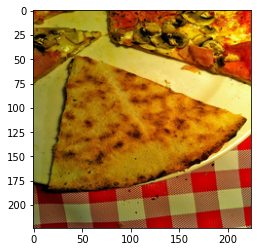

Predicted caption:
 a pizza with cheese and onions on a white plate 

True captions:
Slices of pizza upside down on a plate on a table.
A few pizza slices next to a couple of bread slices.
Two slices of flipped over pizza on a plate.
A pizza sitting on a table, with a couple slices on it.
One of the slices of pizza on the dish is turned upside down. 


In [149]:
generate_caption_coco(idx = 4857, train = False)

In [150]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
# FOR NUMERICAL ANALYTICS
import numpy as np
# TO STORE AND PROCESS DATA IN DATAFRAME
import pandas as pd
import os
# BASIC VISUALIZATION PACKAGE
import matplotlib.pyplot as plt
# ADVANCED PLOTING
import seaborn as seabornInstance

In [156]:
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from discover_feature_relationships import discover
import plotly.figure_factory as ff

In [ ]:
id_limit =4999
idx_num = []
for i in range(id_limit):
    idx_num.append(i+1)
    




app = dash.Dash(__name__, meta_tags=[{"name": "viewport", "content": "width=device-width"}])

app.layout = html.Div([
       

    html.P([
        html.Div([

                    html.P('Select ID:', className='fix_label2',  style={'color': 'white'}),

                     dcc.Dropdown(id='w_id',
                                  multi=False,
                                  clearable=True,
                                  value='1',
                                  placeholder='Select ID of an Image',
                                  options=[{'label': c, 'value': c}
                                           for c in (idx_num)], className='dcc_compon'),
                                          
         

        ], className="card_container one-half column1", id="cross-filter-options2"),
                html.Div([
            
                html.H2("Image Caption Generator", style={"margin-bottom": "0px", 'color': '#F8F8F8', "font-size":"85px", 
                                                          "font-family": "Times New Roman", "text-align":"Left"}),
                
           
        ], className="twelve column", id="title"),
            
  
                 

        ], className="row flex-display"),
    

   
 # for factors card
    html.Div([
          html.Div([
              dcc.Graph(id='Image') ,            
        
              ], className="card_container four columns",
        ),
          html.Div([
              dcc.Graph(id='Captions'),            
        
              ], className="card_container nine columns",
        ),
     
          

       ], className="row flex-display"),
    




    html.Div([
            html.Div([
                html.H4("Mitti Ke Rang | Creator: Pradnya Patil", style={"margin-bottom": "0px", 'color': 'orange',
                                                                        "font-size":"40px", 
                                                                        "font-family": "Times New Roman", 
                                                                        "text-align":"Center"}),

            ])
        ], className="one-half column"), 
    

    ], id="mainContainer",
    style={"display": "flex", "flex-direction": "column"})



@app.callback(
    Output('Image', 'figure'),
    [Input('w_id', 'value')])
def update_image(w_id):
    image_, caption_, pred_ = generate_caption_coco(idx=w_id, train=False)
    
    fig = px.imshow(image_)
    fig.update_layout(
    legend=dict(
        
        bgcolor="#101010",
        bordercolor="#101010",
        
    )
)
    fig.layout.plot_bgcolor = 'black'
    fig.layout.paper_bgcolor = 'black'
    #fig.show()
    return fig
    

    #return "output/display.jpg"

     



@app.callback(
    Output('Captions', 'figure'),
    [Input('w_id', 'value')])
def update_captions(w_id):
        image__, caption__, pred__ = generate_caption_coco(idx=w_id, train=False)
        test = caption__[0]
        predicted_caps= "Predicted Caption"+ "<br>" + '"' + pred__ + '"'"<br><br><br>" + "--------------------------------------------"+ "<br>"+ "Real Captions:" +"<br>"+ "--------------------------------------------"+ "<br>"+"1. "+ caption__[0]+"<br>"+ "2. "+caption__[1]+"<br>"+ "3. "+caption__[2]
        return {
            
            'data': [go.Indicator(
                       
                    domain={'row': 0, 'column': 0})],
            

            
                    
            'layout': go.Layout(
                title={'text': predicted_caps,
                       
                       'xanchor': 'center',
                       'yanchor': 'top'},
                font=dict(color="white", size = 20),
                paper_bgcolor='black',
                plot_bgcolor='black',
                
                ),

            }
     



if __name__ == '__main__':
    app.run_server()